## CH3_단어 임베딩을 사용하여 텍스트 유사성 계산하기

In [ ]:
!pip install nltk

In [7]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/research/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
!pip install gensim
!wget https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip

Traceback (most recent call last):
  File "/usr/bin/pip", line 9, in <module>
    from pip import main
ImportError: cannot import name main


In [83]:
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np

from nltk.tokenize import word_tokenize, sent_tokenize
from lxml import etree
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import FastText

#xml 파일을 읽어옵니다. / <content> ~ </content> 사이의 데이터만 읽어옵니다.
targetXML = open(r'./ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))

#re : 정규표현식 sub 모듈로 (Audio), (Applause) 등을 지웁니다.
content_text = re.sub(r'\([^)]*\)','', parse_text)


In [10]:
#nltk를 이용하여 문장 토큰화를 수행합니다.
sent_text=sent_tokenize(content_text)

#구두점을 제거하고, 대문자를 소문자로
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

#nltk를 이용하여 단어 토큰화를 수행합니다.
result=[]
result=[word_tokenize(sentence) for sentence in normalized_text]

print(result[:10])

[['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new'], ['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation'], ['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing'], ['consider', 'facit'], ['i', 'm', 'actually', 'old', 'enough', 'to', 'remember', 'them'], ['facit', 'was', 'a', 'fantastic', 'company'], ['they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world'], ['everybody', 'used', 'them'], ['and', 'what', 'did', 'facit', 'do', 'when', 'the', 'electronic', 'calculator', 'came', 'along'], ['they', 'continued', 'doing', 'exactly', 'the', 'same']]


In [75]:
from gensim.models import Word2Vec

#word2vec 모델로 100차원 임베딩 사이즈 / 윈도우 크기 5 / sg : 0 - CBOW, 1 - Skip-gram
w2v_model = Word2Vec(sentences=result, size=100, window=5, min_count=1, workers=4, sg=0)
ft_model = FastText(sentences=result, size=100, window=5, min_count=1, workers=4, sg=1)

In [87]:
sim_wv=w2v_model.wv.most_similar("man")
print(sim_wv)

[('woman', 0.8653082847595215), ('guy', 0.815261721611023), ('lady', 0.7825111150741577), ('boy', 0.7710304260253906), ('girl', 0.7672821283340454), ('gentleman', 0.7303575277328491), ('soldier', 0.7184085845947266), ('kid', 0.697036862373352), ('poet', 0.65450519323349), ('writer', 0.6484693288803101)]


In [88]:
sim_ft=ft_model.wv.most_similar("man")
print(sim_ft)

[('madwoman', 0.8591204881668091), ('woman', 0.840608537197113), ('catwoman', 0.8308407068252563), ('charwoman', 0.8281388282775879), ('batsman', 0.822282075881958), ('maman', 0.8216226100921631), ('batman', 0.8210252523422241), ('oxman', 0.8123258352279663), ('guzman', 0.8101592659950256), ('usman', 0.8099648952484131)]


In [89]:
def ABC(a, b, c, topn=1):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    res = w2v_model.wv.most_similar(positive=b + c, negative=a, topn=topn)
    res2 = ft_model.wv.most_similar(positive=b + c, negative=a, topn=topn)
    
    return res[0][0], res2[0][0]

ABC('man', 'woman', 'king')

('luther', 'dancing')

In [90]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
len(items)

18

In [91]:
item_vectors = [(item, w2v_model[item]) 
                    for item in items
                    if item in w2v_model]
len(item_vectors)

/home/research/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/research/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


11

In [92]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 8.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 79.3197327, gradient norm = 0.6725058 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 65.0386200, gradient norm = 0.5248668 (50 iterations in 0.008s)
[t-SNE] Iteration 150: error = 64.4948578, gradient norm = 0.7782242 (50 iterations in 0.008s)
[t-SNE] Iteration 200: error = 46.0015755, gradient norm = 0.0620611 (50 iterations in 0.008s)
[t-SNE] Iteration 250: error = 64.7724686, gradient norm = 0.5616547 (50 iterations in 0.008s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.772469
[t-SNE] Iteration 300: error = 0.4602440, gradient norm = 0.0010574 (50 iterations in 0.007s)
[t-SNE] Iteration 350: error = 0.3192955, gradient norm = 0.0002369 (50 i

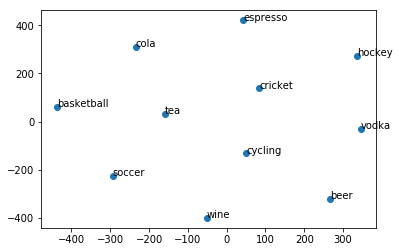

In [96]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=10)

plt.show()